<a href="https://colab.research.google.com/github/imashoodnasir/Fruit-Detection/blob/main/FruitDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import cv2
from xml.etree import ElementTree as et

import torch
import torchvision

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

%matplotlib inline

print(torch.__version__)

1.13.1+cu116


In [2]:
class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        self.classes = [_, 'apple','banana','orange']

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)
   
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        
        img_res /= 255.0
        
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        wt = img.shape[1]
        ht = img.shape[0]
        
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    if isinstance(img, torch.Tensor):
        img = transforms.ToPILImage()(img).convert('RGB')
    a.imshow(img)
    
    boxes = target['boxes']
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()
    
    for box in (boxes):
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        a.add_patch(rect)
    
    plt.show()

In [4]:
# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')

kaggle.json


In [5]:
# Download data
!pip install -q kaggle
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection

 78% 22.0M/28.4M [00:00<00:00, 107MB/s] 
100% 28.4M/28.4M [00:00<00:00, 92.7MB/s]


In [ ]:
!unzip '/content/fruit-images-for-object-detection.zip' -d '/content/dataset/'

In [7]:
files_dir = '/content/dataset/train_zip/train'
test_dir = '/content/dataset/test_zip/test'

dataset = FruitImagesDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

length of dataset =  240 



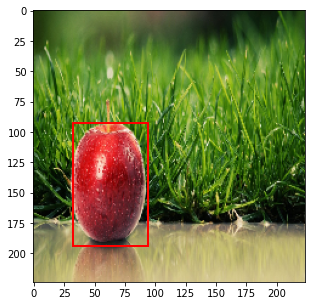

In [8]:
img, target = dataset[31]
plot_img_bbox(img, target)

In [9]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

def get_object_detection_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model


def collate_fn(batch):
    return tuple(zip(*batch))


def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.VerticalFlip(0.3),
            ToTensorV2(p=1.0) 
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [10]:
dataset = FruitImagesDataset(files_dir, 224, 224, transforms=get_transform(train=True))
dataset_test = FruitImagesDataset(test_dir, 224, 224, transforms=get_transform(train=False))

In [11]:
torch.manual_seed(1)
np.random.seed(1)
indices = np.random.permutation(len(dataset)).tolist()

In [12]:
test_split = 0.1
tsize = len(dataset) - int(len(dataset)*test_split)

train_data = torch.utils.data.Subset(dataset, indices[:tsize])
val_data = torch.utils.data.Subset(dataset, indices[tsize:])

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=5, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=5, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

n_batches, n_batches_test = len(train_loader), len(test_loader)

{'boxes': tensor([[ 35.0933,   0.0000, 220.2667, 194.3864]]), 'labels': tensor([3]), 'area': tensor([35995.1836]), 'iscrowd': tensor([0]), 'image_id': tensor([196])}


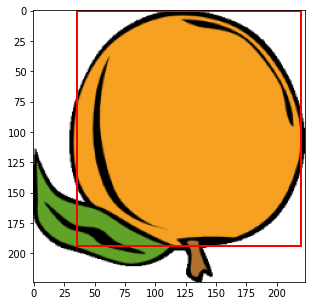

In [15]:
images, targets = next(iter(train_loader))
print(targets[0])
plot_img_bbox(images[0], targets[0])

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4

model = get_object_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
!pip install torchmetrics

In [19]:
import time
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision()

def train_model(model, data_loader=None, num_epoch=10):

    for epoch in range(1, num_epoch + 1):
        print(f"Starting epoch {epoch} of {num_epoch}")

        time_start = time.time()
        loss_accum = 0.0
        # loss_mask_accum = 0.0
        loss_classifier_accum = 0.0
        
        model.train()
        
        for batch_idx, (images, targets) in enumerate(data_loader, 1):

            # Predict
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            # loss_mask = loss_dict['loss_mask'].item()
            loss_accum += loss.item()
            # loss_mask_accum += loss_mask
            loss_classifier_accum += loss_dict['loss_classifier'].item()

            if batch_idx % 500 == 0:
                print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}.")

        lr_scheduler.step()

        # Train losses
        train_loss = loss_accum / n_batches
        # train_loss_mask = loss_mask_accum / n_batches
        train_loss_classifier = loss_classifier_accum / n_batches

        elapsed = time.time() - time_start

        torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
        prefix = f"[Epoch {epoch:2d} / {num_epoch:2d}]"
        # print(prefix)
        # print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}, classifier loss {train_loss_classifier:7.3f}")
        print(f"{prefix} Train loss: {train_loss:7.3f} [{elapsed:.0f} secs]", end=' | ')
        
        preds_single = []
        targets_single = []
        
        for batch_idx, (images, targets) in enumerate(val_loader, 1):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            targets_single.extend(targets)
    
            model.eval()
            with torch.no_grad():
                pred = model(images)
            
            preds_single.extend(pred)
        
        metric.update(preds_single, targets_single)
        batch_map = metric.compute()
        
        print(f"Val mAP: {batch_map['map']}")
        
    return model

In [20]:
num_epoch = 30
model = train_model(model, train_loader, num_epoch)

Starting epoch 1 of 30
[Epoch  1 / 30] Train loss:   0.425 [49 secs] | Val mAP: 0.5220959186553955
Starting epoch 2 of 30
[Epoch  2 / 30] Train loss:   0.210 [45 secs] | Val mAP: 0.49479061365127563
Starting epoch 3 of 30
[Epoch  3 / 30] Train loss:   0.168 [44 secs] | Val mAP: 0.5074412822723389
Starting epoch 4 of 30
[Epoch  4 / 30] Train loss:   0.128 [44 secs] | Val mAP: 0.5166711211204529
Starting epoch 5 of 30
[Epoch  5 / 30] Train loss:   0.125 [45 secs] | Val mAP: 0.5267201066017151
Starting epoch 6 of 30
[Epoch  6 / 30] Train loss:   0.119 [44 secs] | Val mAP: 0.5366396307945251
Starting epoch 7 of 30
[Epoch  7 / 30] Train loss:   0.114 [44 secs] | Val mAP: 0.5456481575965881
Starting epoch 8 of 30
[Epoch  8 / 30] Train loss:   0.112 [44 secs] | Val mAP: 0.5540942549705505
Starting epoch 9 of 30
[Epoch  9 / 30] Train loss:   0.110 [44 secs] | Val mAP: 0.5601072311401367
Starting epoch 10 of 30
[Epoch 10 / 30] Train loss:   0.110 [44 secs] | Val mAP: 0.5645179152488708
Starting

In [21]:
metric_test = MeanAveragePrecision()

preds_single = []
targets_single = []

for batch_idx, (images, targets) in enumerate(test_loader, 1):

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    targets_single.extend(targets)

    model.eval()
    with torch.no_grad():
        pred = model(images)

    preds_single.extend(pred)

metric_test.update(preds_single, targets_single)
test_map = metric.compute()

print(f"Test mAP: {test_map['map']}")

Test mAP: 0.5943784713745117


{'boxes': tensor([[ 53.0133,  58.6900, 130.6667, 160.4192],
        [  8.9600,  21.5197,  78.4000, 108.5764],
        [100.0533,  22.4978, 181.4400, 112.4891],
        [ 79.8933, 123.2489, 161.2800, 224.0000],
        [154.5600, 134.9869, 222.5067, 224.0000]]), 'labels': tensor([1, 1, 1, 1, 1]), 'area': tensor([7899.6167, 6045.2217, 7324.0889, 8199.7949, 6048.1440]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'image_id': tensor([0])}


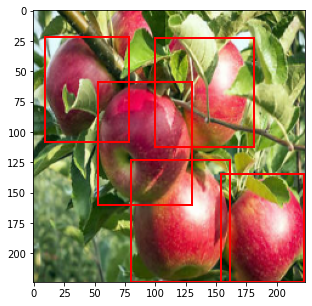

In [22]:
images, targets = next(iter(test_loader))
print(targets[0])
plot_img_bbox(images[0], targets[0])

In [23]:
import torchvision

def apply_threshold(prediction, threshold=0.6):
    index = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    pred = prediction.copy()
    pred['boxes'] = pred['boxes'][index]
    pred['scores'] = pred['scores'][index]
    pred['labels'] = pred['labels'][index]
    
    return pred


def apply_threshold_batch(prediction, threshold=0.1):
    preds = []

    for data in prediction:
        preds.append(apply_threshold(data, threshold))
        
    return preds

In [24]:
model.to(device)
model.eval()
with torch.no_grad():
    prediction = model([images[0].to(device)])

In [25]:
print(prediction)

[{'boxes': tensor([[ 83.5358, 120.5090, 162.0681, 217.0062],
        [ 51.8471,  55.9999, 129.7265, 161.0602],
        [153.9536, 137.4644, 224.0000, 222.5153],
        [  7.7729,  23.3079,  73.8822,  97.5476],
        [117.9861,  25.6816, 185.2368, 117.2339],
        [ 64.6121,   0.0000, 102.5310,  43.7676],
        [ 59.4445,  88.8322, 155.2843, 204.3995],
        [114.9175,  63.9095, 172.3682, 117.2188],
        [120.7501, 137.1288, 200.7893, 216.1068],
        [  6.6095,  48.3458,  56.6718, 104.3593]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.9961, 0.9924, 0.9902, 0.9663, 0.6436, 0.5308, 0.4343, 0.1367,
        0.0676], device='cuda:0')}]


In [26]:
filtered_preds = apply_threshold_batch(prediction, threshold=0.1)
filtered_preds

[{'boxes': tensor([[ 83.5358, 120.5090, 162.0681, 217.0062],
          [153.9536, 137.4644, 224.0000, 222.5153],
          [  7.7729,  23.3079,  73.8822,  97.5476],
          [117.9861,  25.6816, 185.2368, 117.2339],
          [ 64.6121,   0.0000, 102.5310,  43.7676]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9969, 0.9924, 0.9902, 0.9663, 0.6436], device='cuda:0')}]

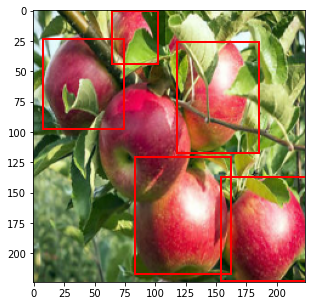

In [27]:
plot_img_bbox(images[0], filtered_preds[0])